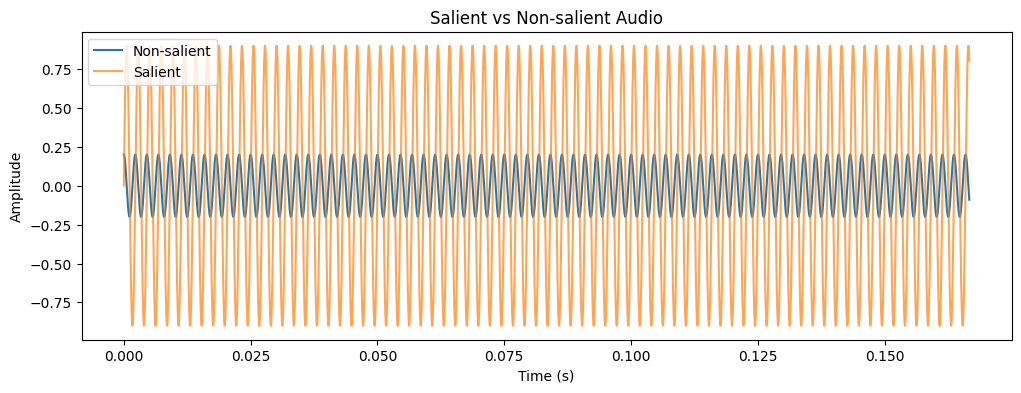

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa  

sampleRate = 48000         # sample rate
duration = 1/6     # seconds
t = np.linspace(0, duration, int(sampleRate*duration), endpoint=False)

# Salient audio: strong 440 Hz sine wave
f_s = 440
salient_audio = 0.9 * np.sin(2 * np.pi * f_s * t)  # high amplitude

# Non-salient audio: quieter, less distinct
f_ns = 440
non_salient_audio = 0.2 * np.cos(2 * np.pi * f_ns * t)  # low amplitude

# Optional: add subtle noise to non-salient audio
# non_salient_audio += 0.05 * np.random.randn(len(t))

# Visualize
plt.figure(figsize=(12,4))
plt.plot(t, non_salient_audio, label="Non-salient")
plt.plot(t, salient_audio, label="Salient", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Salient vs Non-salient Audio")
plt.legend()
plt.show()


In [2]:
def processWave(type, wave, sr):
    # converts this to a Short-Time Fourier Transform. Tells you how much eergy has at each frequency over time.
    # does this by going through windows. Length of each window defined by n_fft. Then, shifts window to right by length
    # hop length. at each window, computes how much of each frequency is present.
    # final value is 2D array of rows being each frequency, columns being time, so value being amplitude/energy for that time and frequency
    stftWave = np.abs(librosa.stft(wave, n_fft=2048, hop_length=512))
    # when we get the mel, that just converts all the frequencies to 128 possible onces, which are moreso frequencies humans can hear. So compressing
    # the frequencies from a large number of frequencies to a smaller number, in this case n_mels amount
    mel = librosa.feature.melspectrogram(S = stftWave, sr= sr, n_mels = 128)
    # converts from power scaling of audio to decibel scaling, cause humans perceive in moreso logarithm of audio (so higher sounds kinda taper off to us)
    logMel = librosa.power_to_db(mel, ref=np.max)

    # gets overall frame energy, including amplitude
    frameEnergy = np.sqrt(np.mean(logMel ** 2, axis=0))
    # gets the contrast in energy between frequencies within a specific frequency band, so where some frequencies bands may have parts of high energy frequencies, while other parts are low energy
    contrast = librosa.feature.spectral_contrast(S = stftWave, sr=sr)
    # combines the difference frequency bands to get a average contrast for that time frame
    contrast = np.mean(contrast, axis=0)
    # basically gets how much the sound chagnes over time. Does this by getting differnece over time fimes with np.diff, squaring that value, and getting its sum
    temporal_novelty = np.sum(np.diff(logMel, axis=1) ** 2, axis=0)
    # do this to add an extra value cause rn, the length is T - 1, since you're getting difference between frames. So add 1 to get it to T length
    temporal_novelty = np.insert(temporal_novelty, 0, 0)

    # standard normalization
    frameEnergyNorm = frameEnergy / np.max(frameEnergy)
    contrastNorm = contrast / np.max(contrast)
    temporal_novelty_norm = temporal_novelty / np.max(temporal_novelty)

    # gets it for the overall time
    finalSaliency = 0.7 * frameEnergyNorm + 0.3 * contrastNorm + 0.2 * temporal_novelty_norm

    secondsIn = 0.1

    index = int(secondsIn * sr)


    print(f"For type of wave {type}, saliency was {finalSaliency[index]}")



processWave("Salient", salient_audio, sampleRate)
processWave("Non-Salient", non_salient_audio, sampleRate)



IndexError: index 4800 is out of bounds for axis 0 with size 16